In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
spark = SparkSession\
    .builder\
    .appName("PythonSQL")\
    .config("spark.hadoop.fs.s3a.s3guard.ddb.region","us-east-2")\
    .config("spark.yarn.access.hadoopFileSystems",os.environ["STORAGE"])\
    .getOrCreate()

#.config("spark.hadoop.fs.s3a.s3guard.ddb.region","us-east-2")\

Setting spark.hadoop.yarn.resourcemanager.principal to pauldefusco


In [14]:
import os
print("https://spark-"+os.environ["CDSW_ENGINE_ID"]+"."+os.environ["CDSW_DOMAIN"])

https://spark-i5ksryzo83c05o5z.ml-4c5feac0-3ec.go01-dem.ylcu-atmi.cloudera.site


In [6]:
#df = spark.read.csv('data/LoanStats_2015_subset.csv')
#df = spark.read.option('inferschema','true').csv('data/original/LoanStats_2015_subset.csv', header=True)

In [7]:
df = spark.read.option('inferschema','true').csv(
  os.environ["STORAGE"] + "/credit_demo/LoanStats_2015_original.csv",
  header=True,
  sep=',',
  nullValue='NA'
)

In [8]:
df.take(2)

[Row(acc_now_delinq=0, acc_open_past_24mths=8, addr_state='KS', all_util=42, annual_inc=65000.0, annual_inc_joint=None, application_type='Individual', avg_cur_bal=10086, bc_open_to_buy=41055, bc_util=17.1, chargeoff_within_12_mths=0, collections_12_mths_ex_med=0, delinq_2yrs=0, delinq_amnt=0, desc='', dti=23.84, dti_joint=None, earliest_cr_line='Nov-2003', emp_length='10+ years', emp_title='Teacher', funded_amnt=12000, funded_amnt_inv=12000, grade='B', home_ownership='MORTGAGE', id='', il_util=61, initial_list_status='w', inq_fi=0, inq_last_12m=0, inq_last_6mths=0, installment=253.79, int_rate='  9.80%', issue_d='Dec-2015', loan_amnt=12000, loan_status='Fully Paid', max_bal_bc=7909, member_id=None, mo_sin_old_il_acct=127, mo_sin_old_rev_tl_op=145, mo_sin_rcnt_rev_tl_op=4, mo_sin_rcnt_tl=1, mort_acc=2, mths_since_last_delinq=None, mths_since_last_major_derog=None, mths_since_last_record=None, mths_since_rcnt_il=1, mths_since_recent_bc=4, mths_since_recent_bc_dlq=None, mths_since_recent_

In [9]:
print(os.environ["STORAGE"] + "data/LoanStats_2015_subset_120321.csv")

s3a://go01-demodata/LoanStats_2015_subset_120321.csv


In [10]:
type(df)

pyspark.sql.dataframe.DataFrame

In [11]:
#df.head()

In [12]:
df.printSchema()

root
 |-- acc_now_delinq: integer (nullable = true)
 |-- acc_open_past_24mths: integer (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- all_util: integer (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- annual_inc_joint: double (nullable = true)
 |-- application_type: string (nullable = true)
 |-- avg_cur_bal: integer (nullable = true)
 |-- bc_open_to_buy: integer (nullable = true)
 |-- bc_util: double (nullable = true)
 |-- chargeoff_within_12_mths: integer (nullable = true)
 |-- collections_12_mths_ex_med: integer (nullable = true)
 |-- delinq_2yrs: integer (nullable = true)
 |-- delinq_amnt: integer (nullable = true)
 |-- desc: string (nullable = true)
 |-- dti: double (nullable = true)
 |-- dti_joint: double (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: integer (nullable = true)
 |-- 

In [13]:
#Printing number of rows and columns:
print('Dataframe Shape')
print((df.count(), len(df.columns)))

Dataframe Shape


(79163, 105)


#### Basic Inspection

In [15]:
#Count number of nulls for each column:
df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,...,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,0,0,0,57791,0,78756,0,0,743,786,...,79163,79163,79163,79163,79163,79163,79163,79163,79163,79163


In [16]:
#It seems like some columns have a lot of nulls while others have very few:
nulls = df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


In [17]:
null_cols = nulls.T[(nulls.T > 1000).any(axis=1)].index

In [18]:
df = df.drop(*null_cols)

In [19]:
#Printing number of rows:
print('Dataframe Shape')
print((df.count(), len(df.columns)))

Dataframe Shape
(79163, 69)


In [20]:
df = df.filter(df.loan_status != '10500')

In [21]:
df.dtypes

[('acc_now_delinq', 'int'),
 ('acc_open_past_24mths', 'int'),
 ('addr_state', 'string'),
 ('annual_inc', 'double'),
 ('application_type', 'string'),
 ('avg_cur_bal', 'int'),
 ('bc_open_to_buy', 'int'),
 ('bc_util', 'double'),
 ('chargeoff_within_12_mths', 'int'),
 ('collections_12_mths_ex_med', 'int'),
 ('delinq_2yrs', 'int'),
 ('delinq_amnt', 'int'),
 ('desc', 'string'),
 ('dti', 'double'),
 ('earliest_cr_line', 'string'),
 ('emp_length', 'string'),
 ('emp_title', 'string'),
 ('funded_amnt', 'int'),
 ('funded_amnt_inv', 'int'),
 ('grade', 'string'),
 ('home_ownership', 'string'),
 ('id', 'string'),
 ('initial_list_status', 'string'),
 ('inq_last_6mths', 'int'),
 ('installment', 'double'),
 ('int_rate', 'string'),
 ('issue_d', 'string'),
 ('loan_amnt', 'int'),
 ('loan_status', 'string'),
 ('mo_sin_old_rev_tl_op', 'int'),
 ('mo_sin_rcnt_rev_tl_op', 'int'),
 ('mo_sin_rcnt_tl', 'int'),
 ('mort_acc', 'int'),
 ('mths_since_recent_bc', 'int'),
 ('num_accts_ever_120_pd', 'int'),
 ('num_actv_b

## KPI Reporting

### What is the target variable and what does it define?

In [22]:
df.select("loan_status").distinct().show()

+------------------+
|       loan_status|
+------------------+
|        Fully Paid|
|           Default|
|   In Grace Period|
|       Charged Off|
|Late (31-120 days)|
|           Current|
| Late (16-30 days)|
+------------------+



In [23]:
#Types of loan status
print(df.groupBy('loan_status').count().show())

+------------------+-----+
|       loan_status|count|
+------------------+-----+
|        Fully Paid|29111|
|           Default|    2|
|   In Grace Period|  641|
|       Charged Off|10795|
|Late (31-120 days)| 1207|
|           Current|37170|
| Late (16-30 days)|  237|
+------------------+-----+

None


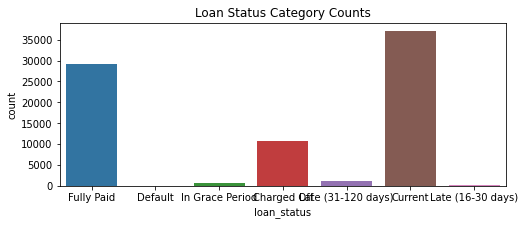

In [24]:
df_plot = df.groupBy('loan_status').count().toPandas()
plt.figure(figsize=(8,3))
g = sns.barplot(x="loan_status", y="count", data=df_plot)
g.set_title('Loan Status Category Counts')
plt.show()

#### To predict defaults, we need to transform the target variable into a binary variable

In [25]:
from pyspark.sql.functions import when

In [26]:
df = df.withColumn("is_default", when((df["loan_status"] == "Charged Off")|(df["loan_status"] == "Default"), 1).otherwise(0))

In [27]:
#Checking that we have correctly replaced values
df.select("is_default").show()

+----------+
|is_default|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         1|
|         0|
|         1|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         1|
|         0|
+----------+
only showing top 20 rows



In [28]:
df.select("is_default").dtypes

[('is_default', 'int')]

In [29]:
from pyspark.sql import functions as F

In [30]:
#Check the exact total of all loans labeled to default matches with the sum of the original two values used above (Charged Off and Default)
df.select(F.sum("is_default")).collect()[0][0]

10797

### What is the monthly total loan volume in dollars and what is the monthly average loan size?

In [31]:
from pyspark.sql.functions import to_date

In [32]:
#The original issue date attribute
df.select("issue_d").show(4)

+--------+
| issue_d|
+--------+
|Dec-2015|
|Dec-2015|
|Dec-2015|
|Dec-2015|
+--------+
only showing top 4 rows



In [33]:
#We need to cast the issue date from string to month (all loan applications in the dataset occurred in 2015 so we don't need the year):
df.selectExpr("from_unixtime(unix_timestamp(issue_d,'MMM-yyyy'),'MM') as issue_month").show(4)

+-----------+
|issue_month|
+-----------+
|         12|
|         12|
|         12|
|         12|
+-----------+
only showing top 4 rows



In [34]:
df = df.withColumn("issue_month",F.from_unixtime(F.unix_timestamp(F.col("issue_d"),'MMM-yyyy'),'MM'))

In [35]:
df.select("issue_month").distinct().show()

+-----------+
|issue_month|
+-----------+
|         11|
|         12|
|         10|
+-----------+



In [36]:
#how many loans defaulted for each month (all data is 2015):
df.groupby('issue_month').sum('is_default').na.drop().sort(F.asc('issue_month')).show()

+-----------+---------------+
|issue_month|sum(is_default)|
+-----------+---------------+
|         10|             11|
|         11|           4612|
|         12|           6174|
+-----------+---------------+



In [37]:
defaults_date = df.groupby('issue_month').sum('is_default').na.drop().sort(F.asc('issue_month')).toPandas()

In [38]:
defaults_date

,issue_month,sum(is_default)
0,10,11
1,11,4612
2,12,6174


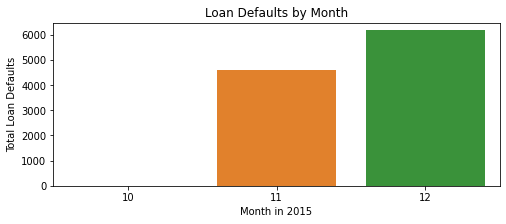

In [39]:
plt.figure(figsize=(8,3))
g = sns.barplot(x="issue_month", y="sum(is_default)", data=defaults_date)
g.set_title('Loan Defaults by Month')
g.set_ylabel('Total Loan Defaults')
g.set_xlabel('Month in 2015')
plt.show()

In [40]:
#Let's create more plots here. First we aggregate in different ways. Then we join, convert to Pandas df, and plot. 

In [41]:
from pyspark.sql.functions import sum as _sum

In [42]:
#by using like function
df.groupBy("issue_month","loan_status").\
count().\
filter(F.lower(F.col("loan_status")).like("late%")).\
groupby('issue_month').\
sum().\
sort(F.asc('issue_month')).\
show()

+-----------+----------+
|issue_month|sum(count)|
+-----------+----------+
|         10|         1|
|         11|       572|
|         12|       871|
+-----------+----------+



In [43]:
df_late = df.groupBy("issue_month","loan_status").\
count().\
filter(F.lower(F.col("loan_status")).like("late%")).\
groupby('issue_month').\
sum().\
sort(F.asc('issue_month'))

In [44]:
#by using like function
df_delinq = df.groupBy("issue_month").\
max("inq_last_6mths").\
na.drop().\
sort(F.asc('issue_month'))

In [45]:
#This time we need to cast the attribute we are working with to numeric before we can create a similar dataframe:
df = df.withColumn('loan_amnt', F.col('loan_amnt').cast('int'))

In [46]:
#by using like function
df_ann_inc = df.groupBy("issue_month").\
mean("loan_amnt").\
na.drop().\
sort(F.asc('issue_month'))

In [47]:
df_delinq.alias('a').join(df_ann_inc.alias('b'),F.col('b.issue_month') == F.col('a.issue_month')).\
join(df_late.alias('c'), F.col('b.issue_month') == F.col('c.issue_month')).\
select(F.col('a.issue_month'), F.col('a.max(inq_last_6mths)'), F.col('b.avg(loan_amnt)'), F.col('c.sum(count)').alias('default_count')).\
show()

+-----------+-------------------+------------------+-------------+
|issue_month|max(inq_last_6mths)|    avg(loan_amnt)|default_count|
+-----------+-------------------+------------------+-------------+
|         11|                  5| 15069.46114242982|          572|
|         12|                  5|15062.594154526183|          871|
|         10|                  4|13712.735849056604|            1|
+-----------+-------------------+------------------+-------------+



In [48]:
df_stats_pd = df_delinq.alias('a').join(df_ann_inc.alias('b'),F.col('b.issue_month') == F.col('a.issue_month')).\
join(df_late.alias('c'), F.col('b.issue_month') == F.col('c.issue_month')).\
select(F.col('a.issue_month'), F.col('a.max(inq_last_6mths)'), F.col('b.avg(loan_amnt)'), F.col('c.sum(count)').alias('default_count')).\
toPandas()

In [49]:
df_stats_pd.head()

,issue_month,max(inq_last_6mths),avg(loan_amnt),default_count
0,11,5,15069.461142,572
1,12,5,15062.594155,871
2,10,4,13712.735849,1


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  


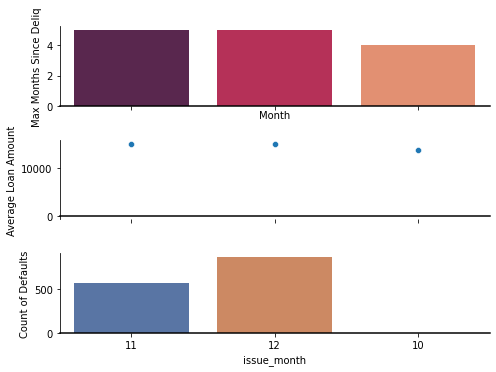

In [50]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 5), sharex=True)

sns.barplot(x=df_stats_pd['issue_month'], y=df_stats_pd['max(inq_last_6mths)'], palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Max Months Since Deliq")
ax1.set_xlabel("")

sns.scatterplot(x=df_stats_pd['issue_month'], y=df_stats_pd['avg(loan_amnt)'], palette="vlag", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Average Loan Amount")

sns.barplot(x=df_stats_pd['issue_month'], y=df_stats_pd['default_count'], palette="deep", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("Count of Defaults")
ax1.set_xlabel("Month")

sns.despine(bottom=True)
#plt.setp(f.axes)
plt.tight_layout(h_pad=2)

plt.show()

In [51]:
#do map based on zipcode?

In [52]:
#df = df.filter(df.loan_status != '10500')

### Spark SQL

In [53]:
##Registering the dataframe as a temporary table:
#df.registerTempTable("LC_Loans_2015")

In [54]:
spark.sql("show databases").show()

Hive Session ID = 363d616c-d216-4735-983c-454ce3dc2f5d


+--------------------+
|           namespace|
+--------------------+
|         01_car_data|
|           01_car_dw|
|      adash_car_data|
|             airline|
|          airline_dw|
|            airlines|
|        airlines_csv|
|       airlines_csv1|
|   airlines_csv_vish|
|    airlines_iceberg|
|   airlines_iceberg1|
|airlines_iceberg_...|
|airlines_iceberg_...|
|      airlines_mjain|
|          airquality|
|                ajvp|
|          atlas_demo|
|            bankdemo|
|          bca_jps_l0|
|          bca_jps_l1|
+--------------------+
only showing top 20 rows



In [55]:
spark.sql("show tables").show()

+---------+------------------+-----------+
|namespace|         tableName|isTemporary|
+---------+------------------+-----------+
|  default|                 t|      false|
|  default|                 s|      false|
|  default|      driver_stats|      false|
|  default|            table1|      false|
|  default|    hue__tmp_test2|      false|
|  default|     employee_ofer|      false|
|  default|      tax_auth_heb|      false|
|  default|   results_anomaly|      false|
|  default|           mytable|      false|
|  default|     shaun_ice_t31|      false|
|  default|      transactions|      false|
|  default|             ice_t|      false|
|  default|ms_churn_prototype|      false|
|  default|         customers|      false|
|  default|            table2|      false|
|  default|           numbers|      false|
|  default|                 a|      false|
|  default| tax_auth_heb_line|      false|
|  default|            syslog|      false|
|  default|        wc_matches|      false|
+---------+

In [56]:
#Looks like revol_bal, tax_liens and tot_cur_bal should be numeric. Revol_util should also be numeric but we'll have to remove the % character

In [57]:
df.write.format('parquet').mode("overwrite").saveAsTable('default.LC_table')

In [58]:
#Running SQL like queries on the dataframe 
group_by_grade = spark.sql("SELECT grade, MEAN(loan_amnt) FROM LC_table WHERE grade IS NOT NULL GROUP BY grade ORDER BY grade")

In [59]:
group_by_grade.show()

+-----+------------------+
|grade|   mean(loan_amnt)|
+-----+------------------+
|    A|14700.964472537053|
|    B|13623.370149747663|
|    C|14929.936085679738|
|    D|16338.372038360285|
|    E| 18897.25658956428|
|    F|19691.007194244605|
|    G|18048.470948012233|
+-----+------------------+



In [60]:
#Transforming to pandas
group_by_grade_pd = group_by_grade.toPandas()

In [61]:
#group_by_grade_pd.set_index('grade', inplace=True)

In [62]:
group_by_subgrade = spark.sql("SELECT sub_grade, MEAN(loan_amnt), MEAN(annual_inc), SUM(is_default) FROM LC_table GROUP BY sub_grade ORDER BY sub_grade")

In [63]:
#cache what you are going to use across queries (and early and often up to available memory)
group_by_subgrade.cache()

DataFrame[sub_grade: string, mean(loan_amnt): double, mean(annual_inc): double, sum(is_default): bigint]

In [64]:
%time group_by_grade.show()

+-----+------------------+
|grade|   mean(loan_amnt)|
+-----+------------------+
|    A|14700.964472537053|
|    B|13623.370149747663|
|    C|14929.936085679738|
|    D|16338.372038360285|
|    E| 18897.25658956428|
|    F|19691.007194244605|
|    G|18048.470948012233|
+-----+------------------+

CPU times: user 0 ns, sys: 2.23 ms, total: 2.23 ms
Wall time: 307 ms


In [65]:
%time group_by_subgrade.show()

+---------+------------------+------------------+---------------+
|sub_grade|   mean(loan_amnt)|  mean(annual_inc)|sum(is_default)|
+---------+------------------+------------------+---------------+
|       A1|14593.534624220545|101184.87480144404|             56|
|       A2|14151.898433792121| 93048.20408163265|             69|
|       A3|14240.865865865866| 97865.88275275276|             68|
|       A4|15154.246165357277|  92540.0866517022|            125|
|       A5|15003.547854785478| 89425.77590251334|            193|
|       B1|13570.545580110498| 85129.55841620626|            262|
|       B2|13533.336989907853| 81736.32716761738|            337|
|       B3|14405.475463051365| 80747.58413022723|            443|
|       B4|13463.995893625342| 77948.91980641376|            532|
|       B5|13086.689697216014| 74548.90872586874|            541|
|       C1|13975.887174541947| 75265.08740790743|            706|
|       C2|14542.473398706446| 74487.55505320258|            632|
|       C3

In [66]:
#caching should reduce loading time for smaller dataframe -- check 
group_by_subgrade.cache()

DataFrame[sub_grade: string, mean(loan_amnt): double, mean(annual_inc): double, sum(is_default): bigint]

In [67]:
%time group_by_subgrade.show()

+---------+------------------+------------------+---------------+
|sub_grade|   mean(loan_amnt)|  mean(annual_inc)|sum(is_default)|
+---------+------------------+------------------+---------------+
|       A1|14593.534624220545|101184.87480144404|             56|
|       A2|14151.898433792121| 93048.20408163265|             69|
|       A3|14240.865865865866| 97865.88275275276|             68|
|       A4|15154.246165357277|  92540.0866517022|            125|
|       A5|15003.547854785478| 89425.77590251334|            193|
|       B1|13570.545580110498| 85129.55841620626|            262|
|       B2|13533.336989907853| 81736.32716761738|            337|
|       B3|14405.475463051365| 80747.58413022723|            443|
|       B4|13463.995893625342| 77948.91980641376|            532|
|       B5|13086.689697216014| 74548.90872586874|            541|
|       C1|13975.887174541947| 75265.08740790743|            706|
|       C2|14542.473398706446| 74487.55505320258|            632|
|       C3

In [68]:
group_by_subgrade_pd = group_by_subgrade.toPandas()

In [69]:
#group_by_subgrade_pd = group_by_subgrade_pd.rename(columns={'avg(CAST(funded_amnt AS DOUBLE))':'avg(funded_amnt)'})

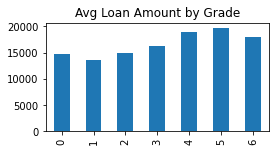

In [70]:
group_by_grade_pd.plot(kind='bar', figsize=(4,2))
plt.title('Avg Loan Amount by Grade')
plt.gca().legend_.remove()
plt.show()
#adjust styling here

In [71]:
#removing from cache
group_by_grade.unpersist()
group_by_subgrade.unpersist()

DataFrame[sub_grade: string, mean(loan_amnt): double, mean(annual_inc): double, sum(is_default): bigint]

Data Quality Checks

In [72]:
#Check dataframe columnns
#df_new.columns

Checking that correct data types were inferred

In [73]:
#The following attributes are strings but they potentially should be numeric. Let's take a look at a sample.
df.select('revol_bal', 'revol_util', 'tax_liens', 'tot_cur_bal', 'int_rate', 'emp_length').show()

+---------+----------+---------+-----------+--------+----------+
|revol_bal|revol_util|tax_liens|tot_cur_bal|int_rate|emp_length|
+---------+----------+---------+-----------+--------+----------+
|     9786|     13.4%|        0|     181540|   9.80%| 10+ years|
|    19339|     42.5%|        0|     430856|   5.32%|    1 year|
|    43413|     51.9%|        0|     193745|  18.49%| 10+ years|
|    21831|     50.3%|        0|     408118|  15.77%|   2 years|
|    12900|    102.4%|        0|     133285|  19.89%|  < 1 year|
|    28475|     51.8%|        0|      42952|  10.78%|   8 years|
|     7179|     39.7%|        0|      10353|  16.59%|   5 years|
|    20862|     54.3%|        0|     305781|   7.49%| 10+ years|
|    31200|       42%|        0|      34856|  13.99%| 10+ years|
|    11008|     41.4%|        0|      31915|  10.78%|   3 years|
|    28705|     56.3%|        0|     265836|  12.88%|    1 year|
|    51507|     64.5%|        0|     221110|   6.49%| 10+ years|
|      732|     31.1%|   

In [74]:
#Removing the % character from revol_util
df = df.withColumn("revol_util", F.expr("substring(revol_util, 1, length(revol_util)-1)"))

In [75]:
#Removing the % character from revol_util
df = df.withColumn("int_rate", F.expr("substring(int_rate, 1, length(revol_util)-1)"))

In [76]:
#Notice that we are not casting emp_length to numeric as the time periods it represents are different - it will have to be one hot encoded
integer = ["revol_bal", "tax_liens", "tot_cur_bal", "funded_amnt"]

In [77]:
for c in integer:
    df = df.withColumn(c, df[c].cast("int"))

In [78]:
#Updating revol_util to double:
df = df.withColumn('revol_util', F.col('revol_util').cast('double'))

In [79]:
#Updating int_rate to double:
df = df.withColumn('int_rate', F.col('int_rate').cast('double'))

In [80]:
for c in integer:
    df = df.withColumn(c, F.col(c).cast('int'))

In [81]:
df.write.format('parquet').mode("overwrite").saveAsTable('default.LC_table')

In [82]:
##Registering the dataframe as a temporary table:
#Temporary views in Spark SQL are session-scoped and will disappear if the session that creates it terminates. 
#If you want to have a temporary view that is shared among all sessions and keep alive until the Spark application terminates, 
#you can create a global temporary view

df.createOrReplaceTempView("LC_Glob_Temp_View")

In [83]:
spark.sql("show tables").show()

+---------+------------------+-----------+
|namespace|         tableName|isTemporary|
+---------+------------------+-----------+
|  default|                 t|      false|
|  default|                 s|      false|
|  default|      driver_stats|      false|
|  default|            table1|      false|
|  default|    hue__tmp_test2|      false|
|  default|     employee_ofer|      false|
|  default|      tax_auth_heb|      false|
|  default|   results_anomaly|      false|
|  default|           mytable|      false|
|  default|     shaun_ice_t31|      false|
|  default|      transactions|      false|
|  default|             ice_t|      false|
|  default|ms_churn_prototype|      false|
|  default|         customers|      false|
|  default|            table2|      false|
|  default|           numbers|      false|
|  default|                 a|      false|
|  default| tax_auth_heb_line|      false|
|  default|            syslog|      false|
|  default|        wc_matches|      false|
+---------+

In [84]:
spark.catalog.dropTempView("LC_Glob_Temp_View")

In [85]:
spark.sql("show tables").show()

+---------+------------------+-----------+
|namespace|         tableName|isTemporary|
+---------+------------------+-----------+
|  default|                 t|      false|
|  default|                 s|      false|
|  default|      driver_stats|      false|
|  default|            table1|      false|
|  default|    hue__tmp_test2|      false|
|  default|     employee_ofer|      false|
|  default|      tax_auth_heb|      false|
|  default|   results_anomaly|      false|
|  default|           mytable|      false|
|  default|     shaun_ice_t31|      false|
|  default|      transactions|      false|
|  default|             ice_t|      false|
|  default|ms_churn_prototype|      false|
|  default|         customers|      false|
|  default|            table2|      false|
|  default|           numbers|      false|
|  default|                 a|      false|
|  default| tax_auth_heb_line|      false|
|  default|            syslog|      false|
|  default|        wc_matches|      false|
+---------+

In [86]:
#spark.catalog.dropGlobalTempView("LC_Loans_2015_GlobalTempView")

In [87]:
spark.sql("SELECT * FROM default.LC_table")

DataFrame[acc_now_delinq: int, acc_open_past_24mths: int, addr_state: string, annual_inc: double, application_type: string, avg_cur_bal: int, bc_open_to_buy: int, bc_util: double, chargeoff_within_12_mths: int, collections_12_mths_ex_med: int, delinq_2yrs: int, delinq_amnt: int, desc: string, dti: double, earliest_cr_line: string, emp_length: string, emp_title: string, funded_amnt: int, funded_amnt_inv: int, grade: string, home_ownership: string, id: string, initial_list_status: string, inq_last_6mths: int, installment: double, int_rate: double, issue_d: string, loan_amnt: int, loan_status: string, mo_sin_old_rev_tl_op: int, mo_sin_rcnt_rev_tl_op: int, mo_sin_rcnt_tl: int, mort_acc: int, mths_since_recent_bc: int, num_accts_ever_120_pd: int, num_actv_bc_tl: int, num_actv_rev_tl: int, num_bc_sats: int, num_bc_tl: int, num_il_tl: int, num_op_rev_tl: int, num_rev_accts: int, num_rev_tl_bal_gt_0: int, num_sats: int, num_tl_30dpd: int, num_tl_90g_dpd_24m: int, num_tl_op_past_12m: int, open_

In [88]:
spark.stop()